<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Survival_Modeling_NNT_Predictions_using_The_CPH_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are using Colab with tensoflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...Please Load Your Drive...")

def time_fmt(t):
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
print(f"test time: {time_fmt(128.1987)}")

Mounted at /content/drive
You are using Colab with tensoflow version: 2.4.1
test time: 0: 002: 08.00


In [ ]:
!pip install scikit-survival

     |████████████████████████████████| 2.3MB 8.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp36-cp36m-linux_x86_64.whl size=4056484 sha256=90d9cd5fe861e2d4cc20bcb3b60f2b5f499a50af2fb2932a240e05b1da55aa9d
  Stored in directory: /root/.cache/pip/wheels/f4/af/94/be84d2dc68a947ad2859b1608f1d57a4328465a0b00b0fb4ac
Successfully built scikit-survival


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from typing import Tuple, Dict, Any, Iterable, Union, Optional
from pathlib import Path
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored


In [ ]:
#Simulation survival data based on mnist images:
#We will obtain survival time as random survival scores coresponding to each digits
#We will first create the class labels for each digit (0, 1, ..., 9)
#Classes will be randomly assigned to four risk groups (0,1,2,3) which discriminate the individual
 

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
#standerdize the data and convert the labels to int:

In [ ]:
x_train, x_test = x_train.astype('float32')/255.0 , x_test.astype('float32')/255.0

In [ ]:
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')

In [ ]:
y = np.concatenate((y_train, y_test)) #Combine the labels

In [ ]:
#Write a function to create a synthetic survival data based on the labels of mnist data:
def create_survival_data(y: np.ndarray,n_groups: int = 4,seed: int = 10)->Tuple[pd.DataFrame, np.array]:
  rnd = np.random.RandomState(seed = seed)

  #Assign class labels (0, 1 2 ..., 9) to risk groups (0,1,2,3):
  classes = np.unique(y) #obtain the unique values for the class variable
  grp_assigment = {}
  grp_members = {}
  groups = rnd.randint(n_groups, size = classes.shape) #First we random Create risk groups (0,1,2,3)
  #Assign classes to risk groups (we assign at random classes 0, 1, ...9) to risk groups (0,1,2,3):
  for label, group in zip(classes, groups):
    grp_assigment[label] = group
    grp_members.setdefault(group, []).append(label) #append (labels fallen on same group) to a group

  #Create survival time/assign risk score to each class label (0, 1,..., 8, 9)
  risk_per_class = {}
  for label in classes:
    grp_index = grp_assigment[label]
    group = grp_members[grp_index]
    label_index = group.index(label)
    group_size = len(group)
    risk_score = np.sqrt(grp_index + 1e-4)*1.75 #Computing the risk score
    risk_score-=(label_index - (group_size)//2)/25. #allow the slight variation accross the group-scores
    risk_per_class[label] = risk_score #create the risk score corresponding to each label (0, 1 2,..., 8,9)
  
  assignment = pd.concat((pd.Series(risk_per_class, name = 'risk_per_class'),
                          pd.Series(grp_assigment, name = 'risk_groups')),axis = 1).rename_axis('class_label')
  risk_scores = np.array([risk_per_class[yy] for yy in y])
  return assignment, risk_scores


In [ ]:
#Create the data by passing the mnist labels:
assignment, risk_scores = create_survival_data(y)

In [ ]:
assignment.round(3)

,risk_per_class,risk_groups
class_label,,
0,1.830,1
1,1.790,1
2,0.058,0
3,3.071,3
4,0.018,0
5,1.750,1
6,3.031,3
7,-0.022,0
8,1.710,1


In [ ]:
#We can see that class labels 3 and 6 belongs to higheast risk group 3 while class labels 2, and 7 belongs to the lowest risk group 0

In [ ]:
#We can now simulate survival times based on the risk scores and by assuming the simplest case of exponential distribution survival time:


In [ ]:
class SurvTimeGen:
  def __init__(self,sample_size: int,mean_surv_time: float,censored_prob: float)->None:
    self.sample_size = sample_size
    self.mean_surv_time = mean_surv_time
    self.censored_prob = censored_prob
  
  def censored_time_gen(self, risk_score: np.ndarray, seed: int = 11)->Tuple[np.ndarray, np.ndarray]:
    '''This function compute censored survival times'''
    rnd = np.random.RandomState(seed = seed)
    base_hazard = 1.0/self.mean_surv_time
    scale = base_hazard * np.exp(risk_score)
    u = rnd.uniform(low = 0, high = 1, size = risk_score.shape[0])
    t = -np.log(u)/scale #This is the survival time based on exponential distribution
    qtl = np.quantile(t, 1.0 - self.censored_prob) 
    c = rnd.uniform(low = t.min(), high = qtl) #indepently from survival times, we Computing the censored times
    #Read the events
    obs_event = t<= c
    obs_time = np.where(obs_event, t, c)
    return obs_time, obs_event


In [ ]:
suv_gen = SurvTimeGen(sample_size = y.shape[0],
                      mean_surv_time = 365.0,
                      censored_prob = 0.45)

In [ ]:
time, events = suv_gen.censored_time_gen(risk_score= risk_scores)

In [ ]:
time_train = time[: y_train.shape[0]]
events_train = events[: y_train.shape[0]]
time_eval = time[y_train.shape[0]:]
events_eval = events[y_train.shape[0]:]

In [ ]:
print(f"right censored train event samples: {np.sum(~events_train) * 100. / len(events_train): .2f}%\nright censored evaluation event samples: {np.sum(~events_eval) * 100. / len(events_eval): .2f}%")

right censored train event samples:  70.06%
right censored evaluation event samples:  70.01%


Text(0.5, 1.0, 'Survival Distribution for the four groups')

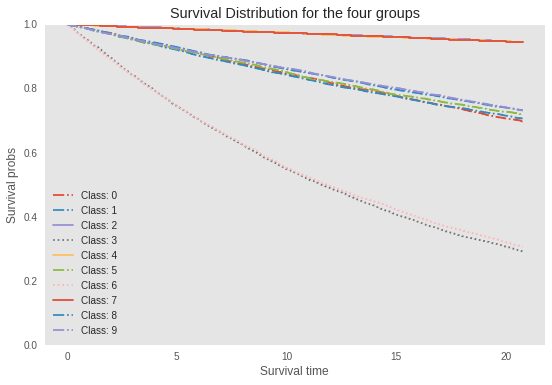

In [ ]:
#Vissualization of the KM survival probabilities with respect to the 4 risks.
#We need to see survival distributions per specific risk. We stratify the data according to the risk groups:
plt.style.use('ggplot')
styles = ('-','-.','--',':')
for row in assignment.itertuples():
  mask = y_train == row.Index
  x_coord, y_coord = kaplan_meier_estimator(events_train[mask], time_train[mask])
  ls = styles[row.risk_groups]
  plt.step(x_coord, y_coord, where = 'post',label = f"Class: {row.Index}", linestyle = ls)
plt.ylim(0,1)
plt.ylabel('Survival probs')
plt.xlabel('Survival time')
plt.grid()
plt.legend()
plt.title('Survival Distribution for the four groups')




In [ ]:
#We see group 7 has the highest survival as we expected since the risk scores are minimum